In [1]:
import pandas as pd
import numpy as np
import datetime
import re
import os
import seaborn as sns
import graphviz
from sklearn import linear_model
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import metrics
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

## Task 1: Read Data

In [24]:
def read_data(filename):
    '''
    PURPOSE: To read a csv into a dataframe
    Input: filename
    Returns: pd dataframe
    '''
    assert os.path.isfile(filename), "File does not exist"
    df = pd.read_csv(filename)
    return df

## Task 2: Explore Data

In [25]:
def data_summary_stats(df, zparam=None, outlier_threshold=None, hist_draw=False):
    '''
    PURPOSE: To produce target summary stats from the dataframe. 
    INPUT:
        df: dataframe
        zparam (float): zscore threshold to label outliers
        outlier_threshsold (int): how many places a feature must be an outlier in order
            to be considered an outlier overall
        hist_draw (bool): flag that dictates whether histograms for features are drawn
        
    RETURNS:
        outlier_dict (dict)
        rd (dict)
    '''
    # assume the first column is the identifying column for all dataframes
    print("Warning: assumes first column is a unique identifier for the df, " +
          "like an ID. Does not calculate all stats for the first column.\n\n")
    colnames = df.columns[1:]
    outlier_dict = {}
    get_corr(df)
    for col in colnames:
        get_column_dist(df, col)
        if type(df[col][0]) is (np.int64 or np.float64):
            df, newcol, outliers = get_zscore(df, col, zparam=zparam)
            if hist_draw:
                df.hist(column=newcol, bins=30)
            outlier_dict[newcol] = outliers
        rd = parse_outlier_dict(df, outlier_dict, threshold=outlier_threshold)
        print("\n Bad outliers are listed as follows - idx: [count, [columns]]")
    
    for k, v in rd.items():
        print("\n\nIndex: ", k)
        print("Count of features it is an outlier for: ", v[0])
        print("Features it is an outlier for: ", [x for x in v[1]])
        
    return outlier_dict, rd

# distributions of per column
def get_column_dist(df, col):
    '''
    PURPOSE: Provide summary descriptions columnwise for a dataframe
    Input: df (pd dataframe), col (str, column name of interest)
    '''
    print("Distributions for ", col)
    print(df[col].describe())
    print("\n\n")
    
# get and label zscore per column
def get_zscore(df, col, zparam=1.96):
    '''
    PURPOSE: Calculate z-score for data and then store as outliers for those with 
    more than a given z-score from mean
    
    INPUTS:
        df (pd dataframe)
        col (str) the column name
        zparam (float) the z-score to consider an outlier. Defaults to 1.96 (p=0.05)
        
    RETURNS:
        df (pd dataframe) that has been updated
        newcol (str) name of the new column
        outliers (list) list of indices pertaining to outlier set
    '''
    newcol = str(col) + "_zscore"
    df[newcol] = df[col].apply(lambda x: (x - df[col].mean()) / df[col].std())
    outliers = df.index[abs(df[newcol]) >= zparam ].tolist()
    return df, newcol, outliers
    
# correlation coefficient heatmap
def get_corr(df):
    '''
    PURPOSE: Generate correlation plot so user can easily visualize which columns 
        are most important
    INPUT: df (pd dataframe)
    '''
    ax = plt.axes()
    currcorr = df.corr()
    sns.heatmap(currcorr, 
        xticklabels = currcorr.columns,
        yticklabels = currcorr.columns,
        vmin = -1.0, 
        vmax = 1.0,
        ax = ax,
        cmap = "RdBu")
    ax.set_title('Correlation matrix')
    # citation: https://datascience.stackexchange.com/
    # questions/10459/calculation-and-visualization-of-
    # correlation-matrix-with-pandas?utm_medium=organic&utm
    # _source=google_rich_qa&utm_campaign=google_rich_qa
    

def parse_outlier_dict(df, outlier_dict, threshold=None):
    '''
    PURPOSE: Parse outliers dict. Retain a dictionary of all outliers per column 
        and any outliers that exist in more than some threshold of columns.
        
    INPUTS: 
        df (pd dataframe) the dataframe
        outlier_dict (dictionary) a dictionary of column names to indices 
            that are outliers per colum
        threshold (int) the number of columns an index must be an outlier for to be 
            considered a "bad" outlier. Defaults to the floor of 1/4 of columns.
            
    RETURNS: rd (dictionary) a dictionary of [index, (# columns, [names of columns])]
    '''
    fill_dict = {}
    rd = {}
    if threshold is None:
        threshold = len([c for c in df.columns if not c.endswith('_zscore')])//4
    print("Finding indices for rows that have outliers in at least ", threshold, "features.\n")
    for k, v in outlier_dict.items():
        for idx in v:
            fill_dict.setdefault(idx, []).append(k)
    for k, v in fill_dict.items():
        if len(fill_dict[k]) >= threshold:
            rd[k] = [len(fill_dict[k]), fill_dict[k]]
            
    return rd

## Task 3: Pre-Process Data

In [4]:
# handle outliers 
def deal_with_outliers(df, outlier_dict, bad_outlier_dict, deletion_option='none', delete_list=None):
    '''
    PURPOSE: Systematically handle outliers in the dataframe
    
    INPUTS:
        df (pd dataframe)
        outlier_dict (dictionary) as above, of column names to indices 
            that are outliers per colum
        bad_outlier_dict (dictionary) as above, of [index, (# columns outlier for, 
            [names of columns])]
        deletion_option (str from set described below):
            all: delete all outliers contained in outlier_dict
            all_extreme: delete all outliers contained in bad_outlier_dict
            none: do not delete any outliers
            manual: delete outliers contained in 'delete_list'
            TO ADD: cap: cap all outliers at 2sd away from the mean
        delete_list (list): provide a list alongside "manual" in order to delete by index
    
    RETURNS:
        updated_df (pd dataframe)
    '''
    assert deletion_option in ["none", "all", "all_extreme", "manual"], "You've entered an invalid deletion option."
    if deletion_option == "none":
        return df
    
    elif deletion_option == "all":
        outlier_idx_list = get_all_outliers(outlier_dict)
    elif deletion_option == "all_extreme":
        outlier_idx_list = get_bad_outliers(bad_outlier_dict)
    elif deletion_option == "manual":
        assert type(delete_list) == list, "You've entered an invalid idx list"
        outlier_idx_list = delete_list
        
    updated_df = df.drop(df.index[outlier_idx_list])
    
    return updated_df

def get_all_outliers(outlier_dict):
    '''
    PURPOSE: read in the outlier dict, formatted as below, in order to produce a list of
        outlier indices. 
    INPUT: outlier dict (dictionary) is 'feature': [idx1, idx2, idx3]
    RETURN: list of outlier idx
    '''
    outlier_idx_set = set()
    for feature, idx_list in outlier_dict.items():
        for i in idx_list:
            outlier_idx_set.add(i)
    return list(outlier_idx_set)

def get_bad_outliers(bad_outlier_dict):
    '''
    PURPOSE: read in the bad outlier dict, formatted as below, in order to produce a list of 
        bad outlier indices.
    INPUT: bad_dict (dictionary) is 'idx':[ct, [features]]
    RETURN: list of outlier idx
    '''
    outlier_idx_set = set()
    for idx in bad_outlier_dict.keys():
        outlier_idx_set.add(idx)
    return list(outlier_idx_set)

In [5]:
def fill_values(df, fill_missing_method='mean'):
    '''
    PURPOSE: To fill in missing values while the dataframe is being preprocessed
    INPUTS:
        df (pd dataframe): dataframe to processs
        fill_missing_method (string): of options below, describes how to fill values
            mean: fill missing values with the mean per feature
            median: fill missing values with median
            
    RETURNS: new_df (pd dataframe) with filled values
    '''
    assert fill_missing_method in ['mean', 'median'], \
        "You've entered an invalid method to fill missing values"
    if fill_missing_method=="mean":
        new_df = df.fillna(df.mean())
        
    if fill_missing_method=="median":
        new_df = df.fillna(df.median())
        
    return new_df

In [6]:
def get_rid_of_no_index_col(df):
    '''
    PURPOSE: This function assumes that the first column is the index column and removes 
    all rows of a df that do not have that index. 
    INPUT: df (pandas dataframe)
    RETURN: new_df (pandas dataframe)
    '''
    new_df = df[df[df.columns[0]].notnull()]
    return new_df

## Task 4: Generate Features/Predictors: 

In [7]:
def make_discretized(df, var_of_interest, num_buckets=4):
    '''
    PURPOSE: Create a discretized variable from a continuous variable
    
    INPUTS: 
        df (pd dataframe)
        var_of_interest (str) colname for the feature you want to discretize
        num_buckets (int) the number of categories you want to create discretized 
            variables for
    
    RETURNS: df (pd dataframe) with appended categorical variable columns
    '''
    working_series = df[var_of_interest]
    new_col_name = str(var_of_interest) + '_category'
    df[new_col_name] = pd.cut(working_series, num_buckets)
    df_append = pd.get_dummies(data=df[new_col_name])
    df = pd.concat([df, df_append], axis=1)
    return df

In [8]:
def get_dummy(df, var_of_interest, threshold=None, thresh_type='>'):
    '''
    PURPOSE: Create a dummy variable from a continuous variable
    
    INPUTS: 
        df (pd dataframe)
        var_of_interest (str) colname for the feature you want to create a dummy for
        threshold (float) the value you want to use to create a dummy on
            !! Will default to the 75% percentile !!
        thresh_type (str from >, >=, <, <=) the type of comparison to your 
            threshold that you want
        
    RETURNS: df (pd dataframe) with appended dummy variable columns 
    '''
    assert thresh_type in ['>', '>=', '<', '<='], "Theshold type is invalid"
    working_series = df[var_of_interest]
    new_col_name = str(var_of_interest) + '_dummy'

    if threshold is None:
        threshold = np.percentile(working_series, 75)
    if thresh_type is '>':
        new_col = np.where(working_series > threshold, 1, 0)
    elif thresh_type is '>=':
        new_col = np.where(working_series >= threshold, 1, 0)
    elif thresh_type is '<':
        new_col = np.where(working_series < threshold, 1, 0)
    elif thresh_type is '<=':
        new_col = np.where(working_series <= threshold, 1, 0)
        
    df[new_col_name] = new_col
    
    return df

In [9]:
def make_categorical_dummy(df=None, cat=None):
    '''
    PURPOSE: transform a categorical variable into a series of dummies
    INPUTS: df (pd dataframe), cat (str colname of the categorical variable)
    RETURNS: df with appended categorical dummies columns
    '''
    df_append = pd.get_dummies(data=df[cat])
    df = pd.concat([df, df_append], axis=1)
    return df

In [10]:
def make_cols_strings(df):
    '''
    PURPOSE: ensure all column names are strings (not interval types)
    INPUTS and RETURNS: df (pd dataframe)
    '''
    df.columns = [str(col) for col in df.columns]
    return df

## Task 5: Build Classifier

In [11]:
def simple_logistic(data=None, feature_list=None, y_column=None):
    '''
    PURPOSE: build a simple logistic model. For the purposes of this assignment, 
        we do not need to split data into test and train data, and so I haven't. 
        
    INPUTS: 
        data (pandas df)
        feature_list (list of colnames): the list of features to include
        y_column (str colname): the column name for what you want to predict
        
    RETURNS: model (sklearn's logistic regression model) fit to all data in the df
    '''
    # this ensures that the data is scaled
    model = Pipeline([
        ('scaler',StandardScaler()),
        ('clf',linear_model.LogisticRegressionCV())
    ])
    # this fits the model
    model = model.fit(data[feature_list], data[y_column])
    return model

In [42]:
def get_simple_decision_tree(data=None,feature_list=None,y_column=None):
    '''
    PURPOSE: build a simple decision tree classifier. For the purposes of this assignment, 
        we do not need to split data into test and train data, and so I haven't. 
        
    INPUTS: 
        data (pandas df)
        feature_list (list of colnames): the list of features to include
        y_column (str colname): the column name for what you want to predict
        
    RETURNS: clf (sklearn's decision tree clf) fit to all data in the df
    '''
    # this ensures that the data is scaled
    model = Pipeline([
        ('scaler',StandardScaler()),
        ('clf',tree.DecisionTreeClassifier())
    ]) 
    model = model.fit(data[feature_list], data[y_column])
    return model

## Task 6: Evaluate Classifier

In [36]:
def validate_clf(data=None,feature_list=None,y_column=None, clf=None):
    '''
    PURPOSE: show stats that evaluate the decision tree. 
        Accuracy score
        Classification report (includes precision, recall, f1-score, and support (n))
        ROC-AUC score
    
    INPUTS:
        data (pandas df)
        feature_list (list of colnames): the list of features to include
        y_column (str colname): the column name for what you want to predict
        clf (classifier): the classsifier to evaluate
    
    '''
    y_pred=clf.predict(data[feature_list])   
    print ("ACCURACY SCORE: {0:.3f}".format(metrics.accuracy_score(data[y_column],y_pred)))
    print ("CLASSIFICATION REPORT\n", metrics.classification_report(data[y_column],y_pred))
    probs = clf.predict_proba(data[feature_list])
    print ("ROC-AUC: {0:.3f}".format(roc_auc_score(data[y_column], probs[:, [1]])), "\n")

## Task 7: Work with this data using wrapper functions

### Preliminary descriptive analysis on data
First, we read in the data and produce summary statistics of the data.

<div class="alert alert-block alert-info"> __Key findings__
- Variables relating to history of defaulting are strongly correlated with each other and among the most correlated with serious delinquency
- Number of dependents and age are also correlated
- Things we do think may be correlated do not show correlation (e.g., zipcode). This may be due to data formatting. 

In [15]:
# task 1
my_data = read_data('./credit-data.csv')



Distributions for  SeriousDlqin2yrs
count    41016.000000
mean         0.161400
std          0.367904
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: SeriousDlqin2yrs, dtype: float64



Finding indices for rows that have outliers in at least  3 features.


 Bad outliers are listed as follows - idx: [count, [columns]]
Distributions for  RevolvingUtilizationOfUnsecuredLines
count    41016.00000
mean         6.37587
std        221.61895
min          0.00000
25%          0.03431
50%          0.18973
75%          0.66716
max      22000.00000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64



Finding indices for rows that have outliers in at least  3 features.


 Bad outliers are listed as follows - idx: [count, [columns]]
Distributions for  age
count    41016.000000
mean        51.683489
std         14.746880
min         21.000000
25%         41.000000
50%         51.000000
75%         62.000000
max        109.

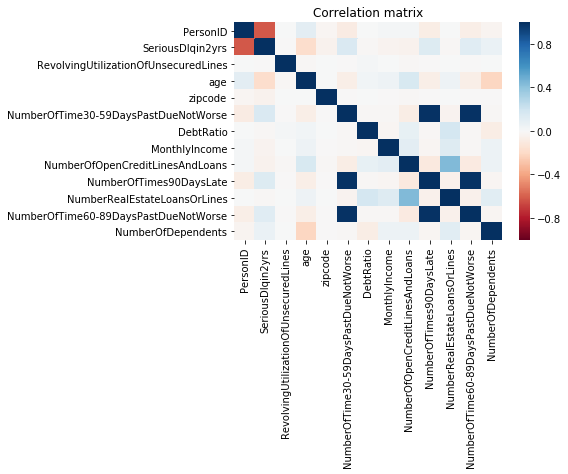

In [16]:
# task 2
od, rd = data_summary_stats(my_data)

### Data cleaning
Next, we clean the data by dealing with outliers and filling missing values.

<div class="alert alert-block alert-info"> __Methods__
- Missing values are filled with the median
- All outliers are retained 
- We check for indices

In [17]:
# task 3a: outliers
new_df = deal_with_outliers(df=my_data, outlier_dict=od, 
                            bad_outlier_dict=rd, deletion_option='none', delete_list=None)

In [18]:
# task 3b: deal with missing valuess
new_df = fill_values(df=new_df, fill_missing_method='median')
new_df.head(10)

,PersonID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,...,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs_zscore,age_zscore,zipcode_zscore,NumberOfTime30-59DaysPastDueNotWorse_zscore,NumberOfOpenCreditLinesAndLoans_zscore,NumberOfTimes90DaysLate_zscore,NumberRealEstateLoansOrLines_zscore,NumberOfTime60-89DaysPastDueNotWorse_zscore
0,98976,0,1.000000,55,60601,0,505.000000,0.0,2,0,...,0,0.0,-0.438702,0.224896,-1.904496,-0.113192,-1.229706,-0.08084,-0.874310,-0.071879
1,98991,0,0.547745,71,60601,0,0.459565,15666.0,7,0,...,0,0.0,-0.438702,1.309871,-1.904496,-0.113192,-0.269520,-0.08084,0.859054,-0.071879
2,99012,0,0.044280,51,60601,0,0.014520,4200.0,5,0,...,0,0.0,-0.438702,-0.046348,-1.904496,-0.113192,-0.653594,-0.08084,-0.874310,-0.071879
3,99023,0,0.914249,55,60601,4,0.794875,9052.0,12,0,...,0,0.0,-0.438702,0.224896,-1.904496,0.655208,0.690666,-0.08084,1.725736,-0.071879
4,99027,0,0.026599,45,60601,0,0.049966,10406.0,4,0,...,0,2.0,-0.438702,-0.453214,-1.904496,-0.113192,-0.845631,-0.08084,-0.874310,-0.071879
5,99033,0,0.142231,57,60601,0,0.015332,13500.0,6,0,...,0,0.0,-0.438702,0.360518,-1.904496,-0.113192,-0.461557,-0.08084,-0.874310,-0.071879
6,99044,0,0.047601,48,60601,0,0.474609,3583.0,13,0,...,0,1.0,-0.438702,-0.249781,-1.904496,-0.113192,0.882704,-0.08084,-0.007628,-0.071879
7,99048,0,0.022141,34,60601,0,0.003332,2700.0,2,0,...,0,1.0,-0.438702,-1.199134,-1.904496,-0.113192,-1.229706,-0.08084,-0.874310,-0.071879
8,99056,0,0.241805,30,60601,0,0.864452,3400.0,13,0,...,0,1.0,-0.438702,-1.470378,-1.904496,-0.113192,0.882704,-0.08084,-0.007628,-0.071879
9,99058,0,0.036181,71,60601,0,0.568798,5050.0,16,0,...,0,0.0,-0.438702,1.309871,-1.904496,-0.113192,1.458815,-0.08084,0.859054,-0.071879


In [19]:
# task 3c: set index
new_df = get_rid_of_no_index_col(df=new_df)

### Changing variables
We wrangle some variables into dummies, categorical, and then categorical dummies. We prepare our data for analysis.
<div class="alert alert-block alert-info"> __Methods__
- We create dummy variables for all histories based on 75% percentile thresholds
- We discretize and then create dummies for zipcode and monthly income

In [20]:
# task 4: get dummies/categorical for at least one variable
new_df = get_dummy(df=new_df, var_of_interest='NumberOfTime30-59DaysPastDueNotWorse', threshold=None, thresh_type='>')
new_df = get_dummy(df=new_df, var_of_interest='NumberOfTime60-89DaysPastDueNotWorse', threshold=None, thresh_type='>')
new_df = get_dummy(df=new_df, var_of_interest='NumberOfTimes90DaysLate', threshold=None, thresh_type='>')
new_df = make_discretized(df=new_df, var_of_interest='MonthlyIncome', num_buckets=15)
new_df = make_categorical_dummy(df=new_df, cat='zipcode')
new_df = make_cols_strings(df=new_df)

### Create and validate clfs
I have chosen to create two classifiers, a decision tree and a logistic mode. In the following cells, I use all of the data to create the models, and then produce precision, recall, f1-score, accuracy, and then roc-auc of each model. 
<div class="alert alert-block alert-info"> __Features used__
- Features selected based on the constraints of the assignment and the original correlation matrix. I weaned down iteratively to a small set that makes sense and produces reasonable results.
- Predicted value: SeriousDlqin2yrs
- Features learned on: NumberOfTime30-59DaysPastDueNotWorse_dummy, NumberOfTime60-89DaysPastDueNotWorse_dummy, NumberOfTimes90DaysLate_dummy, 60601, 60618, 60625, 60629, 60637, 60644, Age, NumberOfDependents

In [49]:
y_column = 'SeriousDlqin2yrs'
feature_list = ['NumberOfTime30-59DaysPastDueNotWorse_dummy',
       'NumberOfTime60-89DaysPastDueNotWorse_dummy',
       'NumberOfTimes90DaysLate_dummy', '60601', '60618',
       '60625', '60629', '60637', '60644', 'age', 'NumberOfDependents']

In [50]:
# task 5: create clfs
logmodel = simple_logistic(data=new_df,
                         feature_list=feature_list, 
                         y_column=y_column)

treemodel = get_simple_decision_tree(data=new_df,
                         feature_list=feature_list, 
                         y_column=y_column)

In [51]:
# task 6: validate clfs
validate_clf(data=new_df,
                         feature_list=feature_list, 
                         y_column=y_column, clf=treemodel)

ACCURACY SCORE: 0.904
CLASSIFICATION REPORT
              precision    recall  f1-score   support

          0       0.90      0.99      0.95     34396
          1       0.90      0.46      0.60      6620

avg / total       0.90      0.90      0.89     41016

ROC-AUC: 0.900 



<div class="alert alert-block alert-info"> These results are actually fairly good. Accuracy is meaningless in general, but we see that precision, recall, and ROC-AUC are all very high.

In [52]:
validate_clf(data=new_df,
                         feature_list=feature_list, 
                         y_column=y_column, clf=logmodel)

ACCURACY SCORE: 0.869
CLASSIFICATION REPORT
              precision    recall  f1-score   support

          0       0.88      0.98      0.93     34396
          1       0.72      0.31      0.43      6620

avg / total       0.85      0.87      0.85     41016

ROC-AUC: 0.832 



<div class="alert alert-block alert-info"> These results are actually fairly good. Accuracy is meaningless in general, but we see that precision, recall, and ROC-AUC are all very high.